In [1]:
import os
import random
import sys
import cv2
import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("hayder17/breast-cancer-detection")
print("Path to dataset files:", path)


train_dir = f"{path}/train"
val_dir = f"{path}/valid"
test_dir = f"{path}/test"


100%|██████████| 87.2M/87.2M [00:01<00:00, 61.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1


In [3]:
# Train data preparation
classes = ["0", "1"]
train_dataset = []
for class_label in classes:
    class_path = os.path.join(train_dir, class_label)
    label_index = classes.index(class_label)
    for img_file in tqdm.tqdm(os.listdir(class_path)):
        img_full_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_full_path)
        img = cv2.resize(img, (224, 224))
        train_dataset.append([img, label_index])

100%|██████████| 803/803 [00:01<00:00, 435.56it/s]


In [4]:
# Test data preparation
test_dataset = []
for class_label in classes:
    class_path = os.path.join(test_dir, class_label)
    label_index = classes.index(class_label)
    for img_file in tqdm.tqdm(os.listdir(class_path)):
        img_full_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_full_path)
        img = cv2.resize(img, (224, 224))
        test_dataset.append([img, label_index])

# Validation data Preparation
val_dataset = []
for class_label in classes:
    class_path = os.path.join(val_dir, class_label)
    label_index = classes.index(class_label)
    for img_file in tqdm.tqdm(os.listdir(class_path)):
        img_full_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_full_path)
        img = cv2.resize(img, (224, 224))
        val_dataset.append([img, label_index])

100%|██████████| 227/227 [00:00<00:00, 350.24it/s]


In [5]:
# Validation data Preparation
val_dataset = []
for class_label in classes:
    class_path = os.path.join(val_dir, class_label)
    label_index = classes.index(class_label)
    for img_file in tqdm.tqdm(os.listdir(class_path)):
        img_full_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_full_path)
        img = cv2.resize(img, (224, 224))
        val_dataset.append([img, label_index])

100%|██████████| 227/227 [00:00<00:00, 387.72it/s]


In [6]:
# Data shuffling
random.shuffle(train_dataset)
random.shuffle(test_dataset)
random.shuffle(val_dataset)

In [7]:
# List to numpy array conversion
# Train data
X_train_images = []
y_train_labels = []
for img, label in train_dataset:
    X_train_images.append(img)
    y_train_labels.append(label)

X_train = np.array(X_train_images)/255
y_train = np.array(y_train_labels)

# Test data
X_test_images = []
y_test_labels = []
for img, label in test_dataset:
    X_test_images.append(img)
    y_test_labels.append(label)

X_test = np.array(X_test_images)/255
y_test = np.array(y_test_labels)

# Validation data
X_val_images = []
y_val_labels = []
for img, label in val_dataset:
    X_val_images.append(img)
    y_val_labels.append(label)

X_val = np.array(X_val_images)/255
y_val = np.array(y_val_labels)

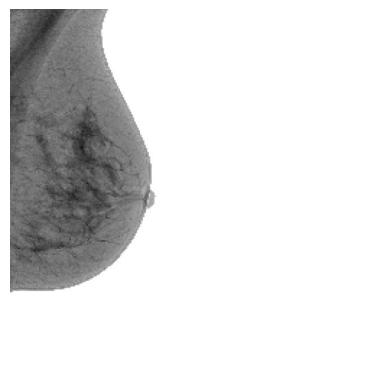

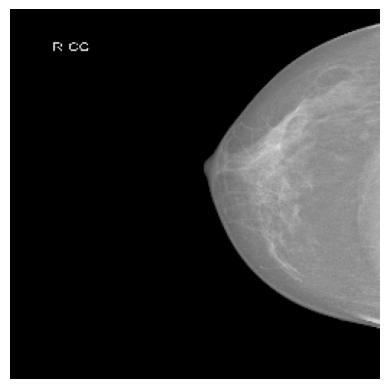

In [8]:
# Load a sample image (replace with the actual path of an image in your dataset)
# Update to the correct image path
sample_image_path = f"{path}/train/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg"

try:
    sample_image = Image.open(sample_image_path).resize((640, 640))
    plt.imshow(sample_image)
    plt.axis('off')  # Turn off the axes for a cleaner visualization
    plt.show()
except FileNotFoundError:
    print("Please replace 'sample_image_path.jpg' with the correct image path on your system.")

# Load a sample image (replace with the actual path of an image in your dataset)
sample_image_path = f"{path}/train//0/106_1160585918_png.rf.ddf71d5395cefb701d0b9ec2b0d81176.jpg"

try:
    sample_image = Image.open(sample_image_path).resize((640, 640))
    plt.imshow(sample_image)
    plt.axis('off')  # Turn off the axes for a cleaner visualization
    plt.show()
except FileNotFoundError:
    print("Please replace 'sample_image_path.jpg' with the correct image path on your system.")

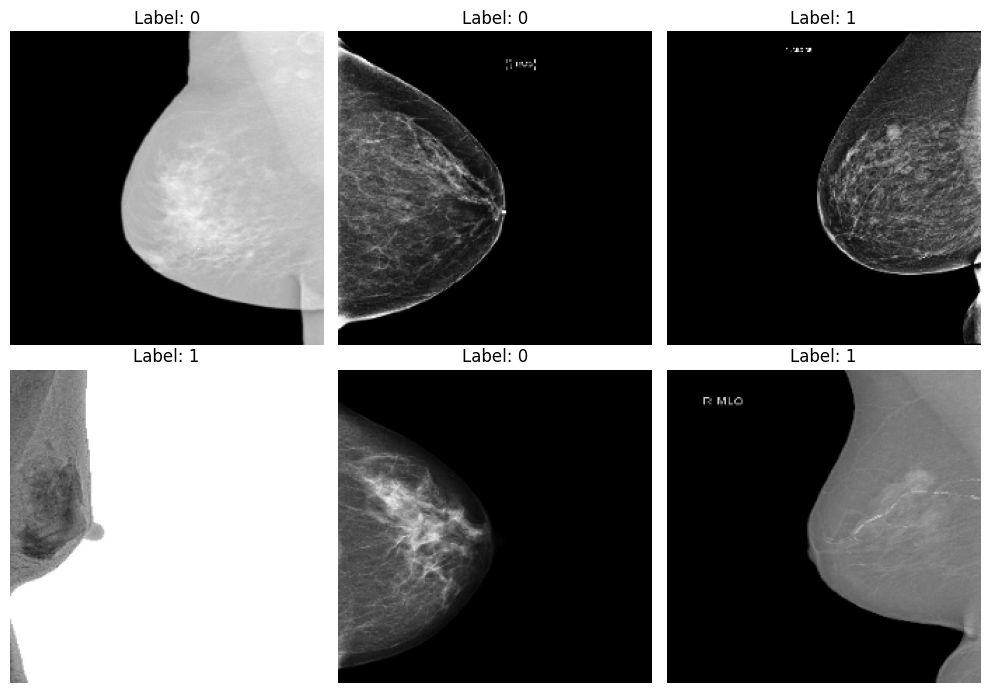

In [9]:
# Sample Visualization
num_samples = 6
random_samples = np.random.choice(len(X_train), num_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, idx in enumerate(random_samples):
    ax = axes[i // 3, i % 3]
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title(f"Label: {y_train[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Initialize a Sequential model
model = Sequential()

# First convolutional layer with 100 filters of size 3x3, using ReLU activation
# The input shape is set to 224x224 pixels with 3 color channels (RGB)
model.add(Conv2D(100, (3, 3), activation="relu", input_shape=(224, 224, 3)))

# First max pooling layer to reduce spatial dimensions (down-sampling by half)
model.add(MaxPooling2D(2, 2))

# Second convolutional layer with 100 filters of size 3x3, using ReLU activation
model.add(Conv2D(100, (3, 3), activation="relu"))

# Second max pooling layer for further down-sampling
model.add(MaxPooling2D(2, 2))

# Third convolutional layer with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Fourth convolutional layer, also with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Third max pooling layer to further reduce spatial dimensions
model.add(MaxPooling2D(2, 2))

# Flatten the feature maps into a 1D vector for the fully connected layers
model.add(Flatten())

# First fully connected layer with 64 units and ReLU activation
model.add(Dense(64, activation="relu"))

# Dropout layer to randomly set 20% of the inputs to zero, preventing overfitting
model.add(Dropout(.2))

# Second fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Dropout layer to randomly set 30% of the inputs to zero, for further regularization
model.add(Dropout(.3))

# Third fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss for binary classification
# Use accuracy as the evaluation metric
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary for an overview of the layers and parameters
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 100)       │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 100)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 100)       │          90,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,750,725 (10.49 MB)

 Trainable params: 2,750,725 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step - accuracy: 0.6425 - loss: 0.6621 - val_accuracy: 0.6637 - val_loss: 0.6378
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6579 - loss: 0.6460 - val_accuracy: 0.6637 - val_loss: 0.6264
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.6579 - loss: 0.6398 - val_accuracy: 0.6637 - val_loss: 0.6248
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.6618 - loss: 0.6350 - val_accuracy: 0.6593 - val_loss: 0.6230
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.6716 - loss: 0.6156 - val_accuracy: 0.6593 - val_loss: 0.6216
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.6832 - loss: 0.5969 - val_accuracy: 0.6637 - val_loss: 0.6184
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.6852 - loss: 0.5929 - val_accuracy: 0.6696 - val_loss: 0.6402
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.6779 - loss: 0.5930 - val_accuracy:

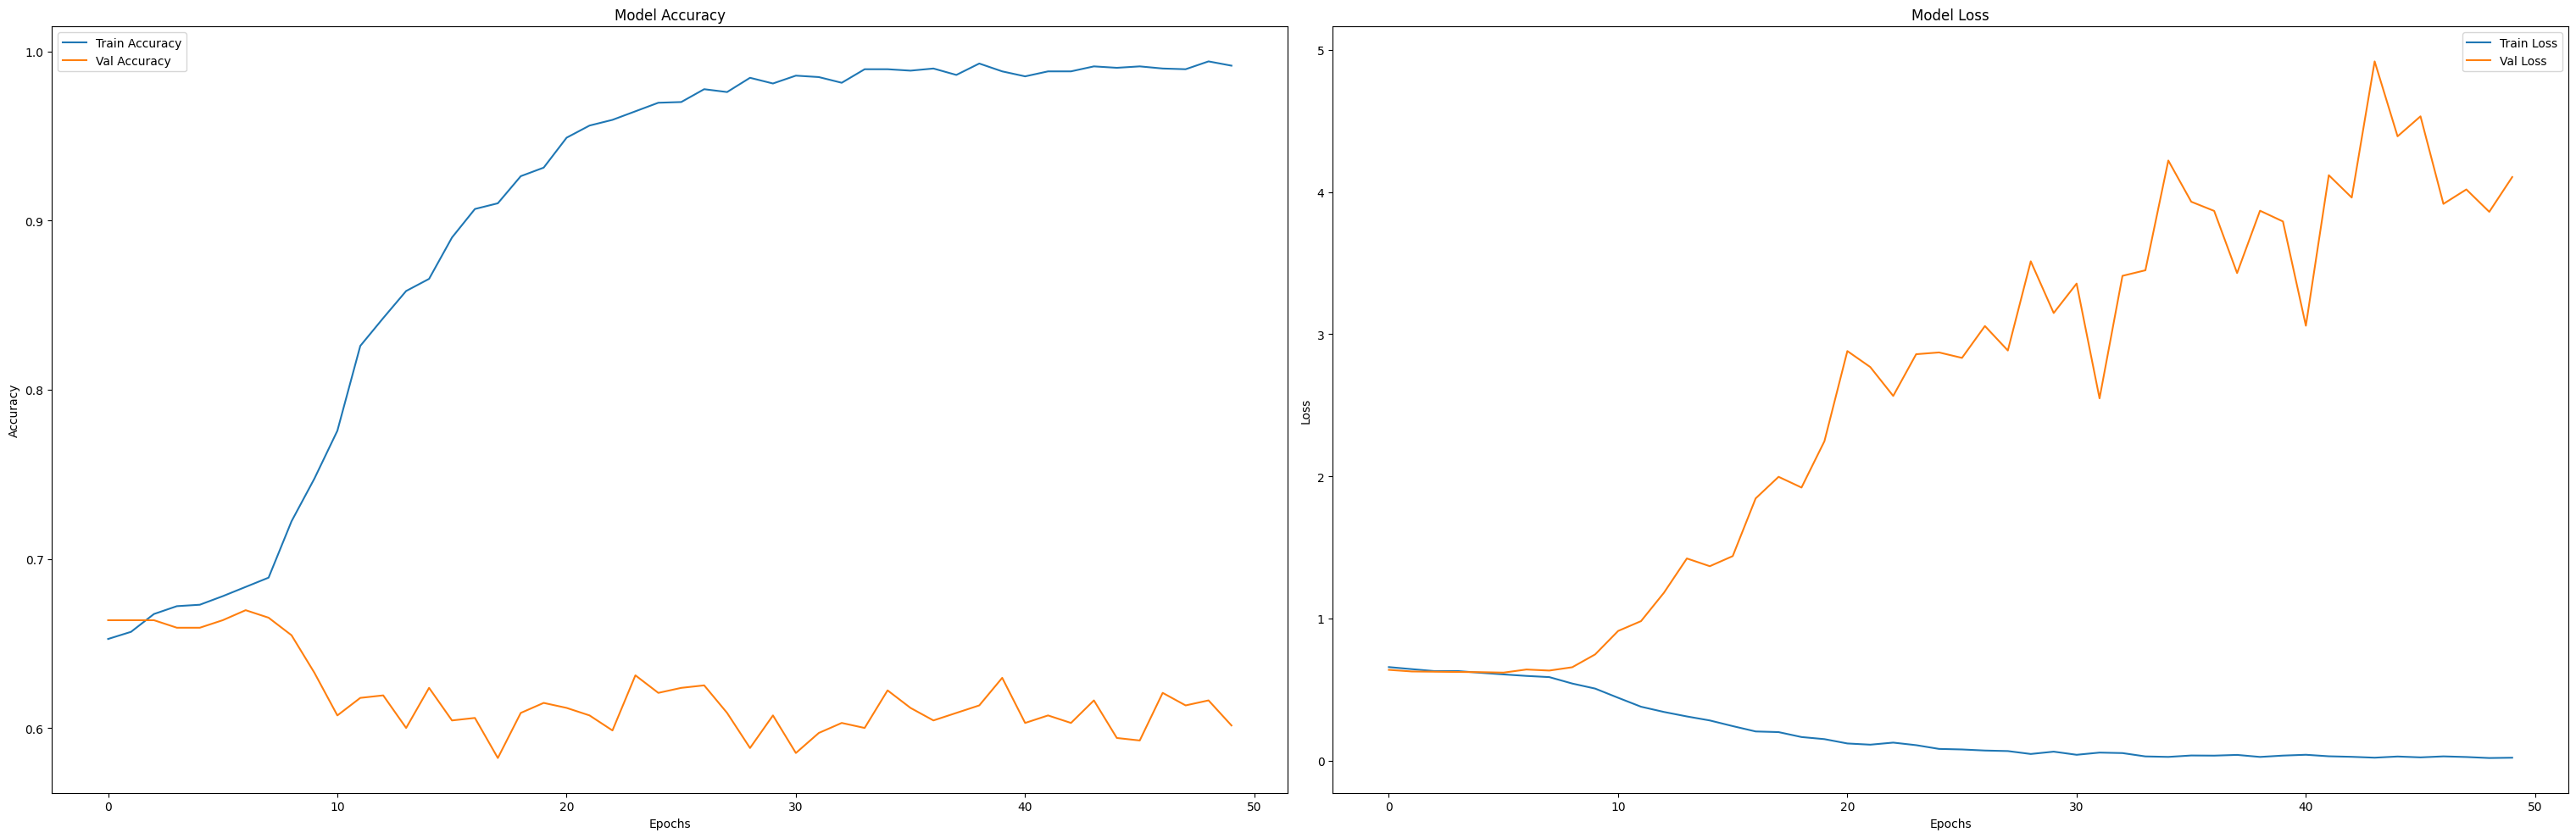

In [12]:
# Graphs and Metrics
plt.figure(figsize=(30.5, 10))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Confusion Matrix
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype(int)

model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6274 - loss: 3.9881


[4.082708835601807, 0.6190476417541504]

<Figure size 800x600 with 0 Axes>

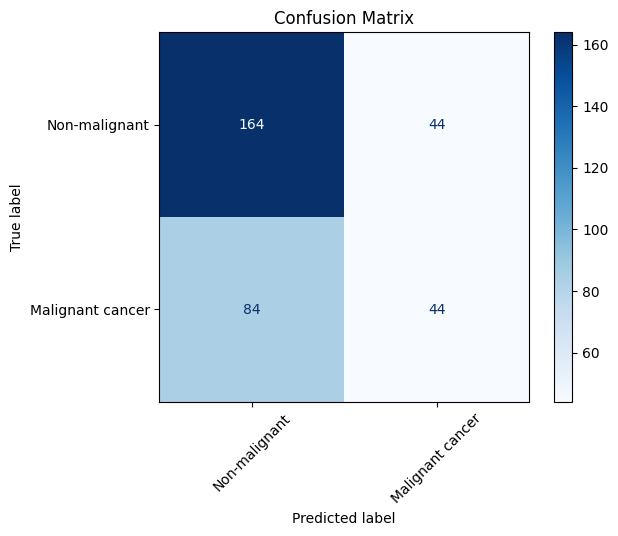

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with custom labels
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-malignant', 'Malignant cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Non-malignant', 'Malignant cancer'])

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
                  precision    recall  f1-score   support

   Non-malignant       0.66      0.79      0.72       208
Malignant cancer       0.50      0.34      0.41       128

        accuracy                           0.62       336
       macro avg       0.58      0.57      0.56       336
    weighted avg       0.60      0.62      0.60       336



In [16]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Create a DataFrame to store the accuracy
accuracy_df = pd.DataFrame({'Metric': ['Accuracy'],
                            'Score': [accuracy]})

# Display the DataFrame
accuracy_df

,Metric,Score
0,Accuracy,0.619048


In [17]:
# Save the model after training
model.save('breast_cancer_model.keras')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


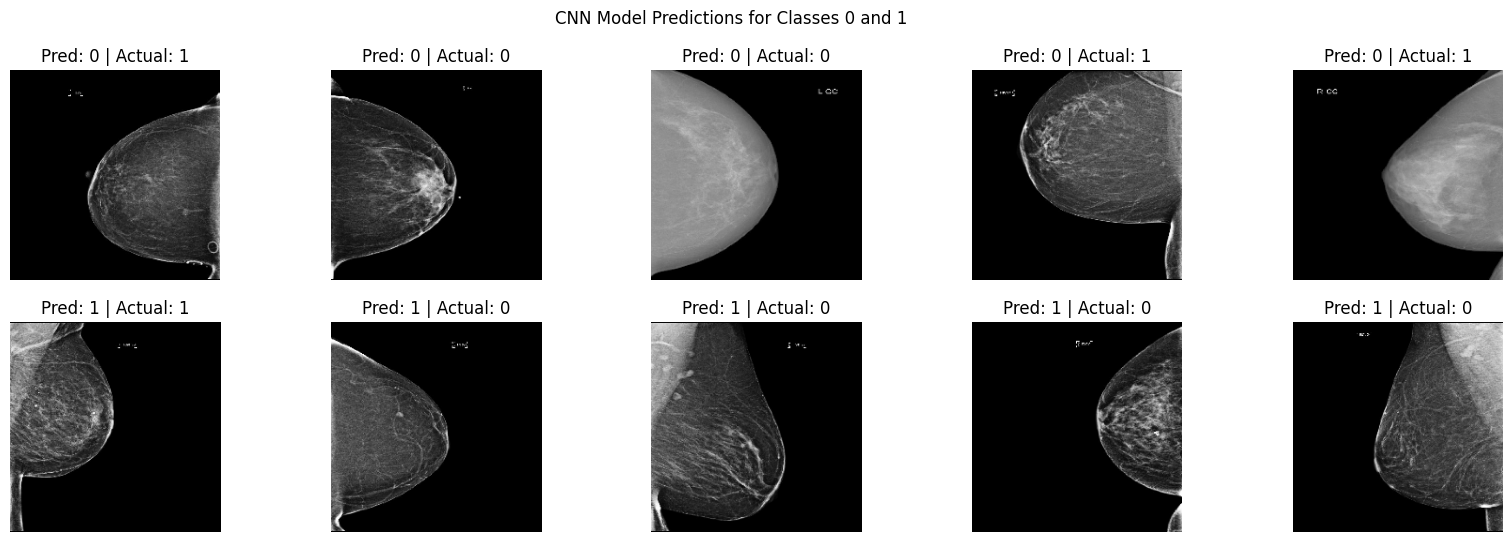

In [18]:
# Assuming X_test and y_test are your test data and labels
predictions = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Separate indices of predicted classes
class_0_indices = np.where(predictions.flatten() == 0)[0]
class_1_indices = np.where(predictions.flatten() == 1)[0]

# Display up to 5 examples for each class
num_examples = 5
fig, axes = plt.subplots(2, num_examples, figsize=(20, 6))

# Plot class 0 predictions
for i, idx in enumerate(class_0_indices[:num_examples]):
    axes[0, i].imshow(X_test[idx])
    axes[0, i].set_title(f"Pred: 0 | Actual: {y_test[idx]}")
    axes[0, i].axis('off')

# Plot class 1 predictions
for i, idx in enumerate(class_1_indices[:num_examples]):
    axes[1, i].imshow(X_test[idx])
    axes[1, i].set_title(f"Pred: 1 | Actual: {y_test[idx]}")
    axes[1, i].axis('off')

# Set row titles
axes[0, 0].set_ylabel("Class 0")
axes[1, 0].set_ylabel("Class 1")

plt.suptitle("CNN Model Predictions for Classes 0 and 1")
plt.show()

In [19]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import glob

In [20]:
# Load the trained model
model = load_model('breast_cancer_model.keras')

# Path to the image to predict
img_path = f'{path}/test/0/1890_712521570_png.rf.6fca80e8b87142cc12b129e85e664eb7.jpg'

# Test loading the image
img_test = cv2.imread(img_path)

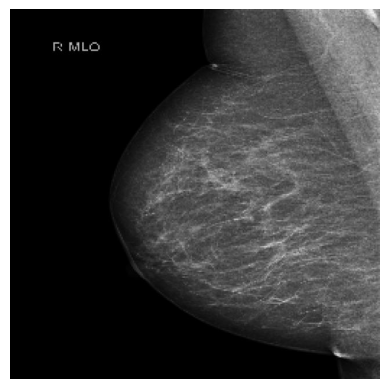

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


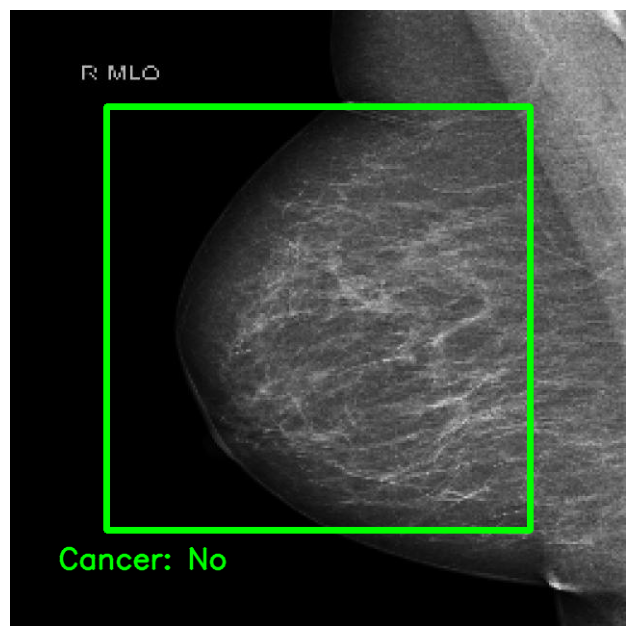

In [21]:
# Check if the image loaded correctly
if img_test is None:
    print("Error loading image. Check the path.")
else:
    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Prediction and display function with a rectangle
def predict_and_display(model, img_path, threshold=0.5):
    # Load the image using OpenCV
    img_cv = cv2.imread(img_path)

    # Make a copy for display
    img_copy = img_cv.copy()

    # Resize image to 224x224 as required by the CNN model
    img_resized = cv2.resize(img_cv, (224, 224))

    # Preprocess the image for the model
    img_array = image.img_to_array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    prediction = model.predict(img_array)

    # Define the label and color based on the prediction
    if prediction[0] >= threshold:
        label = "Cancer: Yes"
        color = (0, 0, 255)  # Red for cancer
    else:
        label = "Cancer: No"
        color = (0, 255, 0)  # Green for no cancer

    # Draw a rectangle around the original image
    height, width, _ = img_copy.shape
    padding = 100  # Adjust for square size
    start_point = (padding, padding)
    end_point = (width - padding, height - padding)

    # Draw the rectangle
    img_with_rectangle = cv2.rectangle(img_copy, start_point, end_point, color, 5)

    # Put the label text on the image
    img_with_text = cv2.putText(img_with_rectangle, label, (50, height - 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img_with_text, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Predict and display
predict_and_display(model, img_path)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Accuracy: 0.62
Precision: 0.50
Recall: 0.34
F1-Score: 0.41

Classification Report:
                precision    recall  f1-score   support

Non-malignant       0.66      0.79      0.72       208
    Malignant       0.50      0.34      0.41       128

     accuracy                           0.62       336
    macro avg       0.58      0.57      0.56       336
 weighted avg       0.60      0.62      0.60       336



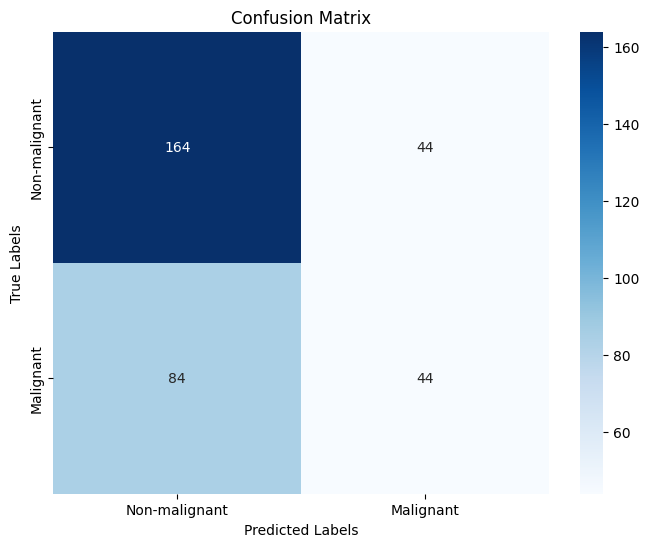

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Non-malignant', 'Malignant'])
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-malignant', 'Malignant'], yticklabels=['Non-malignant', 'Malignant'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


